In [3]:
pip install torch numpy pandas scikit-learn tensorflow shap scikit-optimize openpyxl numpy matplotlib scikit-learn scipy tensorflow boruta


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 8.5 MB/s eta 0:00:00


In [4]:
from BTC_helper import *
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from skopt import BayesSearchCV
import shap

In [13]:
def prepare_data(df, model_type):
    # Separate the dependent and independent variables
    X = df.drop('price_inconsistency', axis=1)
    y = df['price_inconsistency']

    # Split the data into training + validation and test sets
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Then split the training + validation set into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, shuffle=False)

    # Create a MinMaxScaler object
    scaler = MinMaxScaler()

    # Fit the scaler on the training data
    scaler.fit(X_train)

    # Transform the training, validation, and test data
    X_train_scaled = scaler.transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # Reshape the input data to fit the CNN-BiLSTM model (samples, time steps, features)
    if model_type == 'CNN-BiLSTM':
        X_train_scaled = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
        X_val_scaled = np.reshape(X_val_scaled, (X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))
        X_test_scaled = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

    return X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test


def load_date_to_index(file_path):
    df = pd.read_csv(file_path) # Load the csv file
    df['Date'] = pd.to_datetime(df['Date']) # Convert the 'Date' column to datetime format
    # Set the 'Date' column as the index
    df.set_index('Date', inplace=True)
    return df

# Load the preprocessed csv files
kraken_data_encoded_reduced_smooth = pd.read_csv("kraken_data_encoded_reduced_smooth.csv")
coinbase_data_encoded_reduced_smooth = pd.read_csv("coinbase_data_encoded_reduced_smooth.csv")
binance_data_encoded_reduced_smooth = pd.read_csv("binance_data_encoded_reduced_smooth.csv")

# Load and prepare the data
kraken_data_encoded_reduced_smooth = load_date_to_index("kraken_data_encoded_reduced_smooth.csv")
coinbase_data_encoded_reduced_smooth = load_date_to_index("coinbase_data_encoded_reduced_smooth.csv")
binance_data_encoded_reduced_smooth = load_date_to_index("binance_data_encoded_reduced_smooth.csv")

print(kraken_data_encoded_reduced_smooth.shape)
print(coinbase_data_encoded_reduced_smooth.shape)
print(binance_data_encoded_reduced_smooth.shape)

kraken_data_encoded_reduced_smooth.columns

(11455, 23)
(9144, 23)
(11504, 23)


Index(['open', 'volume', 'github_commits', 'google_trends', 'tweets', 'VWAP',
       'OBV', 'MFI', 'ADX', 'MACD', 'MACD_hist', 'RSI', 'WilliamsR',
       'Maker Fee', 'Transaction Fee', 'AML_KYC_required', 'bid_ask_spread',
       'price_inconsistency', 'Coin_BTC', 'Coin_DASH', 'Coin_ETH', 'Coin_LTC',
       'Coin_XRP'],
      dtype='object')

In [15]:
#Make price_inconsistency as the last column in the dataframe
cols = list(kraken_data_encoded_reduced_smooth.columns)
cols.insert(len(cols)-1, cols.pop(cols.index('price_inconsistency')))
kraken_data_encoded_reduced_smooth = kraken_data_encoded_reduced_smooth[cols]
print(kraken_data_encoded_reduced_smooth.columns)

#Make price_inconsistency as the last column in the dataframe
cols = list(coinbase_data_encoded_reduced_smooth.columns)
cols.insert(len(cols)-1, cols.pop(cols.index('price_inconsistency')))
coinbase_data_encoded_reduced_smooth = coinbase_data_encoded_reduced_smooth[cols]
print(coinbase_data_encoded_reduced_smooth.columns)


#Make price_inconsistency as the last column in the dataframe
cols = list(binance_data_encoded_reduced_smooth.columns)
cols.insert(len(cols)-1, cols.pop(cols.index('price_inconsistency')))
binance_data_encoded_reduced_smooth = binance_data_encoded_reduced_smooth[cols]
print(binance_data_encoded_reduced_smooth.columns)


Index(['open', 'volume', 'github_commits', 'google_trends', 'tweets', 'VWAP',
       'OBV', 'MFI', 'ADX', 'MACD', 'MACD_hist', 'RSI', 'WilliamsR',
       'Maker Fee', 'Transaction Fee', 'AML_KYC_required', 'bid_ask_spread',
       'Coin_BTC', 'Coin_DASH', 'Coin_ETH', 'Coin_LTC', 'Coin_XRP',
       'price_inconsistency'],
      dtype='object')
Index(['open', 'volume', 'github_commits', 'google_trends', 'tweets', 'VWAP',
       'OBV', 'MFI', 'ADX', 'MACD', 'MACD_hist', 'RSI', 'WilliamsR',
       'Maker Fee', 'Transaction Fee', 'AML_KYC_required', 'bid_ask_spread',
       'Coin_BTC', 'Coin_DASH', 'Coin_ETH', 'Coin_LTC', 'Coin_XRP',
       'price_inconsistency'],
      dtype='object')
Index(['open', 'volume', 'github_commits', 'google_trends', 'tweets', 'VWAP',
       'OBV', 'MFI', 'ADX', 'MACD', 'MACD_hist', 'RSI', 'WilliamsR',
       'Maker Fee', 'Transaction Fee', 'AML_KYC_required', 'bid_ask_spread',
       'Coin_BTC', 'Coin_DASH', 'Coin_ETH', 'Coin_LTC', 'Coin_XRP',
       'price_inco

In [17]:
kraken_data_encoded_features=apply_feature_selection_RF_Boruta(kraken_data_encoded_reduced_smooth,max_itr=120)  


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Iteration: 	1 / 120
Confirmed: 	0
Tentative: 	22
Rejected: 	0


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Iteration: 	2 / 120
Confirmed: 	0
Tentative: 	22
Rejected: 	0


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Iteration: 	3 / 120
Confirmed: 	0
Tentative: 	22
Rejected: 	0


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Iteration: 	4 / 120
Confirmed: 	0
Tentative: 	22
Rejected: 	0


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Iteration: 	5 / 120
Confirmed: 	0
Tentative: 	22
Rejected: 	0


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Iteration: 	6 / 120
Confirmed: 	0
Tentative: 	22
Rejected: 	0


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Iteration: 	7 / 120
Confirmed: 	0
Tentative: 	22
Rejected: 	0


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Iteration: 	8 / 120
Confirmed: 	14
Tentative: 	0
Rejected: 	8


BorutaPy finished running.

Iteration: 	9 / 120
Confirmed: 	14
Tentative: 	0
Rejected: 	8
==============BORUTA==============
No. of confirmed features 14
[ True  True  True  True  True  True  True  True  True  True  True  True
  True False False False  True False False False False False]
Features that fall into the Acceptance area :  [1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 1 2 2 2 2 2]
Impurity-based feature importances of the forest -               Feature  Ranking
0               open     True
1             volume     True
2     github_commits     True
3      google_trends     True
4             tweets     True
5               VWAP     True
6                OBV     True
7                MFI     True
8                ADX     True
9               MACD     True
10         MACD_hist     True
11               RSI     True
12         WilliamsR     True
13         Maker Fee    False
14   Transaction Fee    False
15  AML_KYC_required  

In [18]:
coinbase_data_encoded_features=apply_feature_selection_RF_Boruta(coinbase_data_encoded_reduced_smooth,max_itr=120)  


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Iteration: 	1 / 120
Confirmed: 	0
Tentative: 	22
Rejected: 	0


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Iteration: 	2 / 120
Confirmed: 	0
Tentative: 	22
Rejected: 	0


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Iteration: 	3 / 120
Confirmed: 	0
Tentative: 	22
Rejected: 	0


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Iteration: 	4 / 120
Confirmed: 	0
Tentative: 	22
Rejected: 	0


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Iteration: 	5 / 120
Confirmed: 	0
Tentative: 	22
Rejected: 	0


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Iteration: 	6 / 120
Confirmed: 	0
Tentative: 	22
Rejected: 	0


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Iteration: 	7 / 120
Confirmed: 	0
Tentative: 	22
Rejected: 	0


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Iteration: 	8 / 120
Confirmed: 	14
Tentative: 	0
Rejected: 	8


BorutaPy finished running.

Iteration: 	9 / 120
Confirmed: 	14
Tentative: 	0
Rejected: 	8
==============BORUTA==============
No. of confirmed features 14
[ True  True  True  True  True  True  True  True  True  True  True  True
  True False False False  True False False False False False]
Features that fall into the Acceptance area :  [1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 1 2 2 2 2 2]
Impurity-based feature importances of the forest -               Feature  Ranking
0               open     True
1             volume     True
2     github_commits     True
3      google_trends     True
4             tweets     True
5               VWAP     True
6                OBV     True
7                MFI     True
8                ADX     True
9               MACD     True
10         MACD_hist     True
11               RSI     True
12         WilliamsR     True
13         Maker Fee    False
14   Transaction Fee    False
15  AML_KYC_required  

In [19]:
binance_data_encoded_features=apply_feature_selection_RF_Boruta(binance_data_encoded_reduced_smooth,max_itr=120)  

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Iteration: 	1 / 120
Confirmed: 	0
Tentative: 	22
Rejected: 	0


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Iteration: 	2 / 120
Confirmed: 	0
Tentative: 	22
Rejected: 	0


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Iteration: 	3 / 120
Confirmed: 	0
Tentative: 	22
Rejected: 	0


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Iteration: 	4 / 120
Confirmed: 	0
Tentative: 	22
Rejected: 	0


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Iteration: 	5 / 120
Confirmed: 	0
Tentative: 	22
Rejected: 	0


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Iteration: 	6 / 120
Confirmed: 	0
Tentative: 	22
Rejected: 	0


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Iteration: 	7 / 120
Confirmed: 	0
Tentative: 	22
Rejected: 	0


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Iteration: 	8 / 120
Confirmed: 	14
Tentative: 	0
Rejected: 	8


BorutaPy finished running.

Iteration: 	9 / 120
Confirmed: 	14
Tentative: 	0
Rejected: 	8
==============BORUTA==============
No. of confirmed features 14
[ True  True  True  True  True  True  True  True  True  True  True  True
  True False False False  True False False False False False]
Features that fall into the Acceptance area :  [1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 1 2 2 2 2 2]
Impurity-based feature importances of the forest -               Feature  Ranking
0               open     True
1             volume     True
2     github_commits     True
3      google_trends     True
4             tweets     True
5               VWAP     True
6                OBV     True
7                MFI     True
8                ADX     True
9               MACD     True
10         MACD_hist     True
11               RSI     True
12         WilliamsR     True
13         Maker Fee    False
14   Transaction Fee    False
15  AML_KYC_required  

In [25]:
#print(kraken_data_encoded_features.columns)
#print(coinbase_data_encoded_features.columns)
#print(binance_data_encoded_features.columns)

#High Correlation Treatment
corr_features_kraken = correlation(kraken_data_encoded_features, 0.95)
print('Kraken correlated features: ', len(set(corr_features_kraken)) )
print(corr_features_kraken)

corr_features_coinbase = correlation(coinbase_data_encoded_features, 0.95)
print('Kraken correlated features: ', len(set(corr_features_coinbase)) )
print(corr_features_coinbase)

corr_features_binance = correlation(binance_data_encoded_features, 0.95)
print('Kraken correlated features: ', len(set(corr_features_binance)) )
print(corr_features_binance)

#Print VIFs after feature selection to check which values to be retained
vif= vif_values(kraken_data_encoded_features).sort_values(by='VIF')
print(vif)
filtered_vif_cols=vif.query("VIF < 10") #Filter out columns with VIF less than 10
filtered_vif_cols.reset_index(level=0, inplace=True) #convert index to column
print("Selected features with VIF <10")
for row in filtered_vif_cols['index']:
    print(row)


Kraken correlated features:  0
set()
Kraken correlated features:  0
set()
Kraken correlated features:  0
set()
                          VIF
github_commits       1.056887
ADX                  1.200129
WilliamsR            1.340994
tweets               1.466851
volume               1.481463
MACD_hist            1.587116
bid_ask_spread       1.599907
google_trends        1.740506
MACD                 1.752163
VWAP                 2.288010
price_inconsistency  2.894241
RSI                  3.539206
MFI                  3.756638
OBV                  3.939206
open                 4.013399
Selected features with VIF <10
github_commits
ADX
WilliamsR
tweets
volume
MACD_hist
bid_ask_spread
google_trends
MACD
VWAP
price_inconsistency
RSI
MFI
OBV
open


In [26]:

# Prepare the data
model_type="CNN-BiLSTM" # "" if 2D shape is required
kraken_X_train_scaled, kraken_X_val_scaled, kraken_X_test_scaled, kraken_y_train, kraken_y_val, kraken_y_test = prepare_data(kraken_data_encoded_features,model_type)
coinbase_X_train_scaled, coinbase_X_val_scaled, coinbase_X_test_scaled, coinbase_y_train, coinbase_y_val, coinbase_y_test = prepare_data(coinbase_data_encoded_features,model_type)
binance_X_train_scaled, binance_X_val_scaled, binance_X_test_scaled, binance_y_train, binance_y_val, binance_y_test = prepare_data(binance_data_encoded_features,model_type)

print("Kraken data")
print(kraken_X_train_scaled.shape)
print(kraken_X_val_scaled.shape)
print(kraken_X_test_scaled.shape)

print("")
print("Coinbase data")
print(coinbase_X_train_scaled.shape)
print(coinbase_X_val_scaled.shape)
print(coinbase_X_test_scaled.shape)

print("")
print("Binance data")
print(binance_X_train_scaled.shape)
print(binance_X_val_scaled.shape)
print(binance_X_test_scaled.shape)

Kraken data
(6873, 1, 14)
(2291, 1, 14)
(2291, 1, 14)

Coinbase data
(5486, 1, 14)
(1829, 1, 14)
(1829, 1, 14)

Binance data
(6902, 1, 14)
(2301, 1, 14)
(2301, 1, 14)


In [27]:
#print(binance_data_encoded_reduced_smooth)
kraken_data_encoded_features.columns
#high VIF remove

Index(['open', 'volume', 'github_commits', 'google_trends', 'tweets', 'VWAP',
       'OBV', 'MFI', 'ADX', 'MACD', 'MACD_hist', 'RSI', 'WilliamsR',
       'bid_ask_spread', 'price_inconsistency'],
      dtype='object')

In [28]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from skopt import BayesSearchCV
import shap
from functools import partial
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt.plots import plot_convergence

# Custom Dataset class to work with PyTorch DataLoader
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create custom PyTorch model
class CNNBiLSTM(nn.Module):
    def __init__(self, input_size, conv_filters, lstm_units, dense_units, dropout_rate):
        super(CNNBiLSTM, self).__init__()
        self.conv1 = nn.Conv1d(1, conv_filters, kernel_size=input_size, padding=0)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.bilstm = nn.LSTM(conv_filters, lstm_units, bidirectional=True, batch_first=True)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(2*lstm_units, dense_units)
        self.fc2 = nn.Linear(dense_units, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = x.transpose(1, 2)  # Transpose the dimensions to make the output compatible with LSTM
        x, _ = self.bilstm(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Define the search space for hyperparameters
search_space = [Integer(32, 128, name='conv_filters'),
                Integer(32, 128, name='lstm_units'),
                Integer(16, 64, name='dense_units'),
                Real(1e-4, 1e-2, prior='log-uniform', name='learning_rate'),
                Real(0.1, 0.5, name='dropout_rate'),
                Integer(8, 64, name='batch_size'),
                Real(1e-6, 1e-1, prior='log-uniform', name='l2_reg')]


def train_evaluate_model(params, X_train_scaled, y_train, X_val_scaled, y_val):
    print(f"Current params: {params}")  # Add this line to print the params list
    conv_filters = params[0]
    lstm_units = params[1]
    dense_units = params[2]
    learning_rate = 0.001 #params[3]
    dropout_rate = .2 #params[4]
    batch_size = int(params[5])  # Convert batch_size to an integer
    l2_reg=params[6]

    model = CNNBiLSTM(X_train_scaled.shape[2], conv_filters, lstm_units, dense_units, dropout_rate)

    criterion = nn.MSELoss()
    optimizer = optim.Adamax(model.parameters(), lr=learning_rate,weight_decay=l2_reg)
    
    train_dataset = TimeSeriesDataset(X_train_scaled, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    val_dataset = TimeSeriesDataset(X_val_scaled, y_val)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Train the model
    epochs = 100
    patience = 4
    min_val_loss = np.inf
    counter = 0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            outputs = torch.squeeze(outputs)  # Add this line to remove the extra dimension
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                outputs = model(batch_X)
                outputs = torch.squeeze(outputs)  # Add this line to remove the extra dimension
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()

        print(f'Epoch: {epoch+1}/{epochs}, Training Loss: {running_loss/len(train_loader):.4f}, Validation Loss: {val_loss/len(val_loader):.4f}')

        if val_loss < min_val_loss:
            min_val_loss = val_loss
            counter = 0
        else:
            counter += 1

        if counter >= patience:
            break

    return val_loss



Optimizing hyperparameters for kraken exchange...
Current params: [89, 113, 57, 0.004948840736375756, 0.349425478714389, 30, 3.073781785362612e-05]
Epoch: 1/100, Training Loss: 25.0799, Validation Loss: 17.5052
Epoch: 2/100, Training Loss: 15.4651, Validation Loss: 46.2032
Epoch: 3/100, Training Loss: 11.1135, Validation Loss: 62.5835
Epoch: 4/100, Training Loss: 10.4614, Validation Loss: 70.9453
Epoch: 5/100, Training Loss: 9.7098, Validation Loss: 57.5111
Current params: [37, 58, 39, 0.004210536704211823, 0.291990868950023, 30, 0.015149343663386152]
Epoch: 1/100, Training Loss: 27.9200, Validation Loss: 24.1254
Epoch: 2/100, Training Loss: 22.8858, Validation Loss: 19.3886
Epoch: 3/100, Training Loss: 18.7559, Validation Loss: 14.3958
Epoch: 4/100, Training Loss: 15.1466, Validation Loss: 20.9160
Epoch: 5/100, Training Loss: 13.1817, Validation Loss: 30.3646
Epoch: 6/100, Training Loss: 12.2924, Validation Loss: 40.0570
Epoch: 7/100, Training Loss: 11.8172, Validation Loss: 39.4315
C

Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Epoch: 1/100, Training Loss: 28.7249, Validation Loss: 11.7749
Epoch: 2/100, Training Loss: 24.0366, Validation Loss: 8.8707
Epoch: 3/100, Training Loss: 19.5105, Validation Loss: 9.2678
Epoch: 4/100, Training Loss: 13.8832, Validation Loss: 14.7479
Epoch: 5/100, Training Loss: 11.4701, Validation Loss: 31.3609
Epoch: 6/100, Training Loss: 10.7859, Validation Loss: 34.6127
Current params: [63, 36, 46, 0.008277487569782088, 0.3611161268021964, 44, 0.09473224693917257]
Epoch: 1/100, Training Loss: 30.7018, Validation Loss: 13.5982
Epoch: 2/100, Training Loss: 25.2571, Validation Loss: 12.7012
Epoch: 3/100, Training Loss: 23.5477, Validation Loss: 10.7470
Epoch: 4/100, Training Loss: 20.1546, Validation Loss: 7.8236
Epoch: 5/100, Training Loss: 16.1754, Validation Loss: 8.2023
Epoch: 6/100, Training Loss: 13.7741, Validation Loss: 10.6428
Epoch: 7/100, Training Loss: 12.0504, Validation Loss: 18.5300
Epoch: 8/100, Training Loss: 11.2982, Validation Loss: 24.8376
Current params: [88, 72, 3

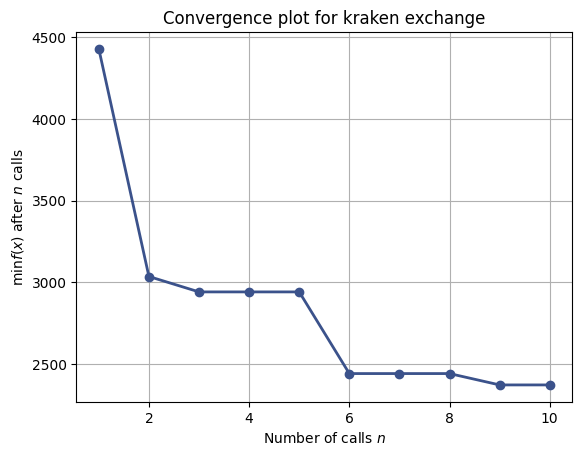

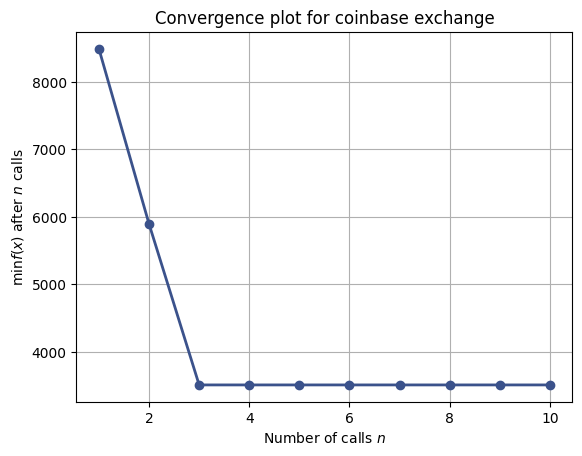

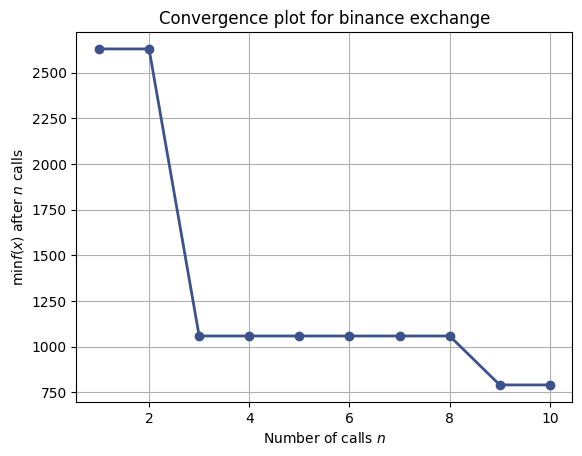

In [29]:
import numpy as np
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt.plots import plot_convergence
from skopt import gp_minimize
import matplotlib.pyplot as plt

# Create a dictionary to store the optimal hyperparameters for each exchange
optimal_params = {}

for exchange in ['kraken', 'coinbase', 'binance']:
    print(f"Optimizing hyperparameters for {exchange} exchange...")

    # Load the data
    X_train_scaled = globals()[f'{exchange}_X_train_scaled']
    y_train = globals()[f'{exchange}_y_train']
    X_val_scaled = globals()[f'{exchange}_X_val_scaled']
    y_val = globals()[f'{exchange}_y_val']

    # Define the objective function for optimization
    @use_named_args(search_space)
    def objective(**params):
        return train_evaluate_model(list(params.values()), X_train_scaled, y_train, X_val_scaled, y_val)

    # Run the optimization
    res_gp = gp_minimize(objective, search_space, n_calls=10, random_state=0)

    # Store the optimal hyperparameters
    optimal_params[exchange] = res_gp.x

    # Plot the convergence
    plt.figure()
    plot_convergence(res_gp)
    plt.title(f'Convergence plot for {exchange} exchange')
    plt.savefig(f'{exchange}_convergence.png', dpi=300)

# Save the optimal hyperparameters
np.save('optimal_params.npy', optimal_params)


In [39]:
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error

# Load the optimal hyperparameters
optimal_params = np.load('optimal_params.npy', allow_pickle=True).item()

import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from math import sqrt

import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from math import sqrt

import matplotlib.pyplot as plt

def train_evaluate_model_final(params, X_train_scaled, y_train, X_test_scaled, y_test):
    print(len(params))

    conv_filters = params[0]
    lstm_units = params[1]
    dense_units = params[2]
    learning_rate = params[3]
    dropout_rate = params[4]
    batch_size = int(params[5])  # Convert batch_size to an integer
    l2_reg = params[6]

    model = CNNBiLSTM(X_train_scaled.shape[2], conv_filters, lstm_units, dense_units, dropout_rate)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_reg)

    train_dataset = TimeSeriesDataset(X_train_scaled, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Train the model
    epochs = 200
    patience = 15
    best_loss = float('inf')
    no_improvement_count = 0
    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            outputs = torch.squeeze(outputs)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Evaluate the model on the test data
        test_dataset = TimeSeriesDataset(X_test_scaled, y_test)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        test_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                batch_predictions = model(batch_X)
                test_loss += criterion(batch_predictions.squeeze(), batch_y).item()

        avg_train_loss = train_loss / len(train_loader)
        avg_test_loss = test_loss / len(test_loader)
        
        train_losses.append(avg_train_loss)
        test_losses.append(avg_test_loss)
        
        print(f'Epoch: {epoch+1}/{epochs}')
        print(f'Train Loss: {avg_train_loss:.6f} | Test Loss: {avg_test_loss:.6f}')

        # Check for early stopping
        if test_loss < best_loss:
            best_loss = test_loss
            no_improvement_count = 0
        else:
            no_improvement_count += 1

        if no_improvement_count >= patience:
            print('Early stopping')
            break

    # Evaluate the model on the training data
    model.eval()
    train_predictions = []
    with torch.no_grad():
        for batch_X, _ in train_loader:
            batch_predictions = model(batch_X)
            train_predictions.extend(batch_predictions.numpy())
    train_rmse = sqrt(mean_squared_error(y_train, train_predictions))
    train_mae = mean_absolute_error(y_train, train_predictions)
    train_mape = mean_absolute_percentage_error(y_train, train_predictions)



    # Evaluate the model on the test data
    test_predictions = []
    with torch.no_grad():
        for batch_X, _ in test_loader:
            batch_predictions = model(batch_X)
            test_predictions.extend(batch_predictions.numpy())
    test_rmse = sqrt(mean_squared_error(y_test, test_predictions))
    test_mae = mean_absolute_error(y_test, test_predictions)
    test_mape = mean_absolute_percentage_error(y_test, test_predictions)

    print(f'Final Train RMSE: {train_rmse:.6f} | Final Test RMSE: {test_rmse:.6f}')
    print(f'Final Train MAE: {train_mae:.6f} | Final Test MAE: {test_mae:.6f}')
    print(f'Final Train MAPE: {train_mape:.6f} | Final Test MAPE: {test_mape:.6f}')

   
    # Plot the training and testing loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train')
    plt.plot(test_losses, label='Test')
    plt.title('Loss over epochs')
    plt.xlabel('Epochs')

    # Plot the predicted and true values
    # Convert lists to numpy arrays
    test_predictions = np.array(test_predictions)
    y_test = np.array(y_test)

    # Create a range of indices
    x_range = np.arange(len(y_test))

    
    plt.figure(figsize=(10,5))
    plt.plot(x_range, y_test, label='True Values')
    plt.plot(x_range, test_predictions, label='Predicted Values')
    plt.title('True vs Predicted Values')
    plt.legend()
    plt.show()


def train_for_exchange(exchange):
    print(f"Training model for {exchange} exchange...")
    

    # Load the data
    X_train_scaled = globals()[f'{exchange}_X_train_scaled']
    y_train = globals()[f'{exchange}_y_train']
    X_test_scaled = globals()[f'{exchange}_X_test_scaled']
    y_test = globals()[f'{exchange}_y_test']

    # Get the optimal hyperparameters for this exchange
    params = optimal_params[exchange]

    # Train and evaluate the model
    train_evaluate_model_final(params, X_train_scaled, y_train, X_test_scaled, y_test)




Training model for kraken exchange...
7
Epoch: 1/200
Train Loss: 19.691592 | Test Loss: 74.231011
Epoch: 2/200
Train Loss: 9.742495 | Test Loss: 53.373596
Epoch: 3/200
Train Loss: 9.476303 | Test Loss: 16.563985
Epoch: 4/200
Train Loss: 8.540707 | Test Loss: 35.163123
Epoch: 5/200
Train Loss: 8.726471 | Test Loss: 7.000688
Epoch: 6/200
Train Loss: 8.145365 | Test Loss: 12.857189
Epoch: 7/200
Train Loss: 8.026109 | Test Loss: 12.940235
Epoch: 8/200
Train Loss: 8.023835 | Test Loss: 4.411463
Epoch: 9/200
Train Loss: 7.602331 | Test Loss: 4.424929
Epoch: 10/200
Train Loss: 7.683726 | Test Loss: 2.868053
Epoch: 11/200
Train Loss: 6.975290 | Test Loss: 2.042752
Epoch: 12/200
Train Loss: 6.882261 | Test Loss: 2.250828
Epoch: 13/200
Train Loss: 7.468050 | Test Loss: 1.874249
Epoch: 14/200
Train Loss: 6.804249 | Test Loss: 1.758338
Epoch: 15/200
Train Loss: 6.641972 | Test Loss: 1.545131
Epoch: 16/200
Train Loss: 6.565347 | Test Loss: 1.515839
Epoch: 17/200
Train Loss: 6.285562 | Test Loss: 1.

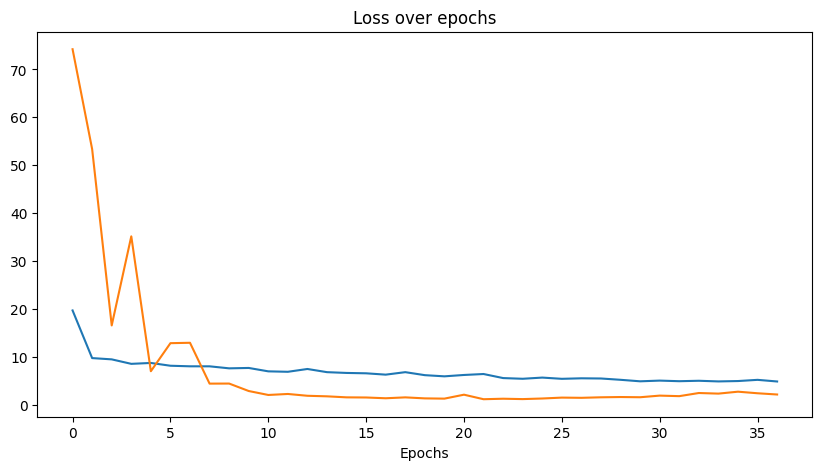

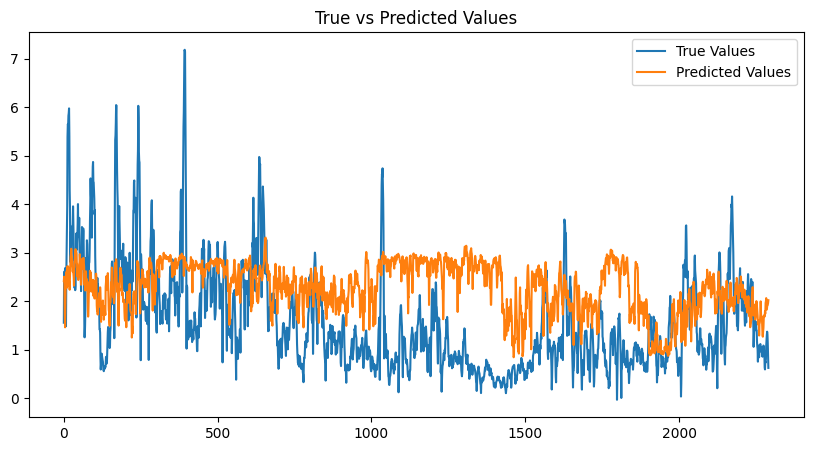

In [31]:
# Exchange for which model needs to be trained
exchange = 'kraken'  # Change this to 'coinbase' or 'binance' as needed

# Train the model for the specific exchange
train_for_exchange(exchange)

Training model for coinbase exchange...
7


Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Epoch: 1/200
Train Loss: 16.294170 | Test Loss: 94.907076
Epoch: 2/200
Train Loss: 8.650887 | Test Loss: 65.639623
Epoch: 3/200
Train Loss: 8.079274 | Test Loss: 99.297971
Epoch: 4/200
Train Loss: 7.652148 | Test Loss: 72.448062
Epoch: 5/200
Train Loss: 7.595468 | Test Loss: 75.740541
Epoch: 6/200
Train Loss: 6.987748 | Test Loss: 76.054044
Epoch: 7/200
Train Loss: 6.890581 | Test Loss: 38.415250
Epoch: 8/200
Train Loss: 8.807366 | Test Loss: 74.985158
Epoch: 9/200
Train Loss: 7.520500 | Test Loss: 52.921267
Epoch: 10/200
Train Loss: 6.688600 | Test Loss: 61.859779
Epoch: 11/200
Train Loss: 6.457000 | Test Loss: 25.893306
Epoch: 12/200
Train Loss: 6.389118 | Test Loss: 32.892155
Epoch: 13/200
Train Loss: 5.757041 | Test Loss: 27.613617
Epoch: 14/200
Train Loss: 5.811242 | Test Loss: 33.671921
Epoch: 15/200
Train Loss: 5.413923 | Test Loss: 31.274332
Epoch: 16/200
Train Loss: 5.513236 | Test Loss: 12.222200
Epoch: 17/200
Train Loss: 5.787763 | Test Loss: 14.581057
Epoch: 18/200
Train Lo

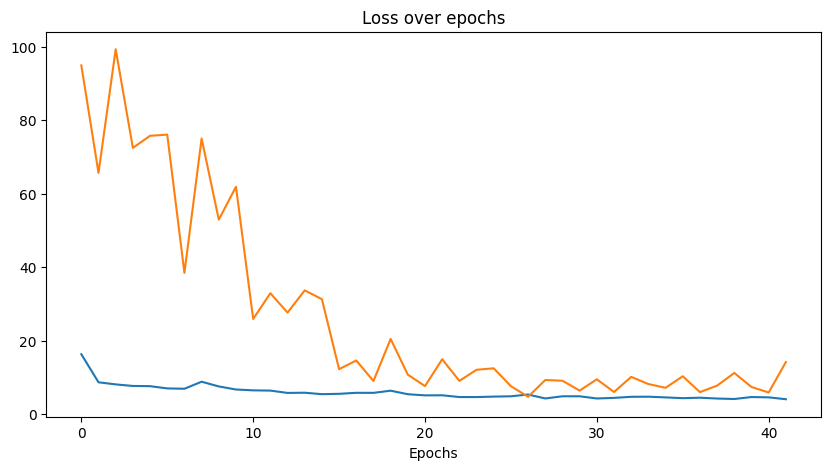

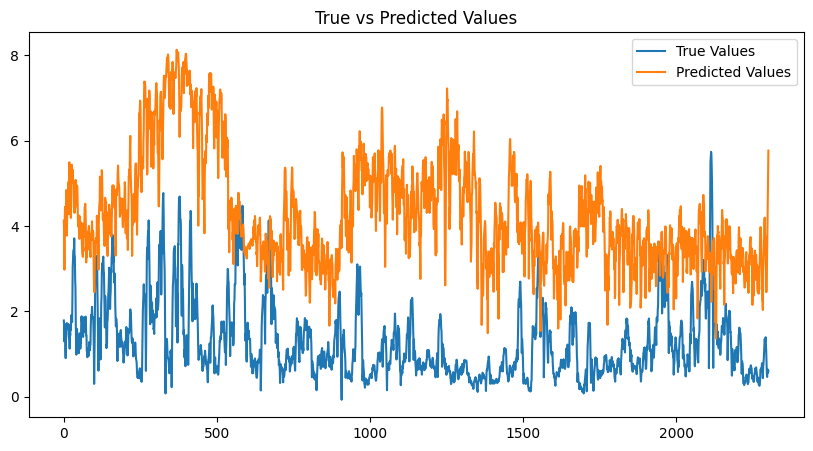

In [40]:
# Exchange for which model needs to be trained
exchange = 'coinbase'  # Change this to 'coinbase' or 'binance' as needed

# Train the model for the specific exchange
train_for_exchange(exchange)



Training model for binance exchange...
7


Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Epoch: 1/200
Train Loss: 18.290241 | Test Loss: 158.864024
Epoch: 2/200
Train Loss: 8.648468 | Test Loss: 152.718525
Epoch: 3/200
Train Loss: 7.745629 | Test Loss: 111.047720
Epoch: 4/200
Train Loss: 7.598848 | Test Loss: 144.271654
Epoch: 5/200
Train Loss: 7.265664 | Test Loss: 127.537052
Epoch: 6/200
Train Loss: 6.687062 | Test Loss: 141.067826
Epoch: 7/200
Train Loss: 6.477815 | Test Loss: 97.829949
Epoch: 8/200
Train Loss: 6.272401 | Test Loss: 69.691045
Epoch: 9/200
Train Loss: 5.675538 | Test Loss: 50.561341
Epoch: 10/200
Train Loss: 5.297620 | Test Loss: 113.134650
Epoch: 11/200
Train Loss: 5.508338 | Test Loss: 18.976087
Epoch: 12/200
Train Loss: 5.430882 | Test Loss: 21.585748
Epoch: 13/200
Train Loss: 5.284410 | Test Loss: 10.260176
Epoch: 14/200
Train Loss: 5.557479 | Test Loss: 16.283309
Epoch: 15/200
Train Loss: 5.209815 | Test Loss: 16.305988
Epoch: 16/200
Train Loss: 5.161942 | Test Loss: 15.381906
Epoch: 17/200
Train Loss: 4.933298 | Test Loss: 17.509576
Epoch: 18/200
T

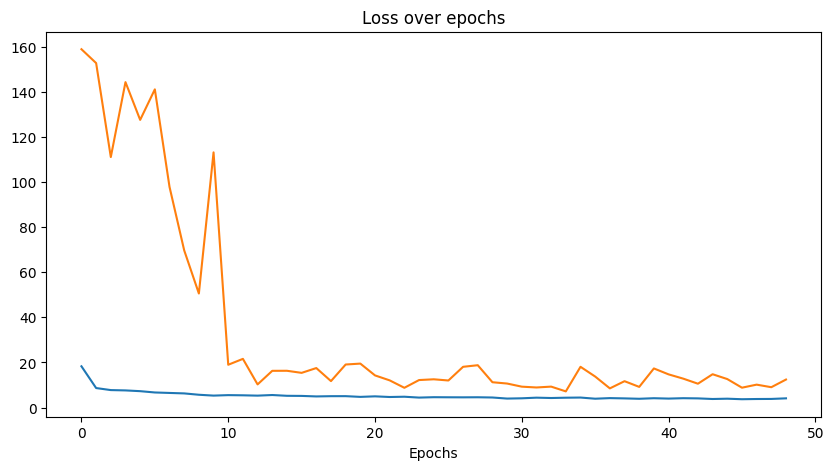

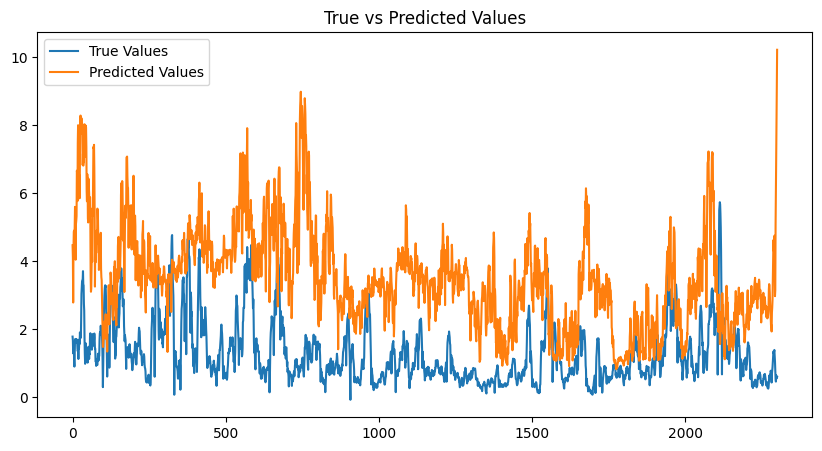

In [33]:
# Exchange for which model needs to be trained
exchange = 'binance'  # Change this to 'coinbase' or 'binance' as needed

# Train the model for the specific exchange
train_for_exchange(exchange)